# Financial Fraud Detection

- The objective of this notebook is to showcase the usage of the [___financial-fraud-training___ container](https://catalog.ngc.nvidia.com/orgs/nvidia/teams/cugraph/containers/financial-fraud-training) and how to deploy the produced trained models on [NVIDIA Dynamo-Triton](https://catalog.ngc.nvidia.com/orgs/nvidia/containers/tritonserver).
- We use [IBM TabFormer](https://github.com/IBM/TabFormer) as an example dataset and the dataset is preprocess before model training

NOTE:
* The preprocessing code is written specifically for the TabFormer dataset and will not work with other datasets.
* Additionally, a familiarity with [Jupyter](https://docs.jupyter.org/en/latest/what_is_jupyter.html) is assumed.

# Environment Setup (Sagemaker studio)
This Notebook is designed to work in a Sagemaker studio jupyter lab notebook

Please create a Conda environment and add that to the notebook - See the [README - Setup Development Environment section](../README.md) file

In [1]:
!nvidia-smi --version

NVIDIA-SMI version  : 580.95.05
NVML version        : 580.95
DRIVER version      : 580.95.05
CUDA Version        : 13.0


### Activate the env in the kernel

Now choose the `fraud_blueprint_env` kernel from within jupyterlab for this notebook

-----
## Import libraries

In [2]:
import os
import sys
import json
import time
import boto3

## Prepare the AWS Environment variables from the infrastructure stack

In [3]:
def get_cfn_output(stack_name, output_key):
    try:
        response = cfn_client.describe_stacks(StackName=stack_name)
        outputs = response['Stacks'][0]['Outputs']
        for output in outputs:
            if output['OutputKey'] == output_key:
                return output['OutputValue']
        return None
    except Exception as e:
        if 'AccessDenied' in str(e) or 'UnauthorizedOperation' in str(e):
            print(f"Permission Error: You don't have permission to access CloudFormation stack '{stack_name}'.")
            print("   Please ensure the Sagemaker execution role has the 'cloudformation:DescribeStacks' permission.")
        else:
            print(f"Error accessing CloudFormation stack '{stack_name}': {str(e)}")
            print("   Please check that the stack exists and you have the permissions to read from it configured.")
        return None

def get_inference_host():
    try:
        response = elb_client.describe_load_balancers()["LoadBalancers"]
        
        for elb in response:
            if elb['LoadBalancerName'].startswith('k8s-triton'):
                return elb['DNSName']
        return None
    except Exception as e:
        if 'AccessDenied' in str(e) or 'UnauthorizedOperation' in str(e):
            print(f"Permission Error: You don't have permission to access Elastic Load Balancers.")
            print("   Please ensure the Sagemaker execution role has the 'elasticloadbalancing:DescribeLoadBalancers' permission.")
        else:
            print(f"Error accessing load balancers: {str(e)}")
            print("   Please check your AWS credentials and network connectivity.")
        return None

In [4]:
import socket
import boto3

# Test 1: Check DNS resolution for CloudFormation endpoint
print("Test 1: DNS Resolution")
try:
    ip = socket.gethostbyname('cloudformation.us-east-1.amazonaws.com')
    print(f"✓ CloudFormation resolves to: {ip}")
    if ip.startswith('172.31.'):
        print("  → Resolving to VPC endpoint (good!)")
    else:
        print("  → Resolving to public IP (BAD - VPC endpoint not being used!)")
except Exception as e:
    print(f"✗ DNS resolution failed: {e}")

# Test 2: Try CloudFormation API call with timeout
print("\nTest 2: CloudFormation API Call")
try:
    cfn = boto3.client('cloudformation', region_name='us-east-1')
    # Set a short timeout to see if it's hanging
    import botocore.config
    config = botocore.config.Config(connect_timeout=5, read_timeout=5)
    cfn_timeout = boto3.client('cloudformation', region_name='us-east-1', config=config)

    response = cfn_timeout.describe_stacks(StackName="NvidiaFraudDetectionBlueprintModelExtractor")
    print("✓ CloudFormation API call succeeded!")
except Exception as e:
    print(f"✗ CloudFormation API call failed: {type(e).__name__}: {e}")

Test 1: DNS Resolution
✓ CloudFormation resolves to: 172.31.89.175
  → Resolving to VPC endpoint (good!)

Test 2: CloudFormation API Call
✓ CloudFormation API call succeeded!


In [5]:
ssm_client = boto3.client('ssm')
cfn_client = boto3.client('cloudformation')
elb_client = boto3.client('elbv2', region_name="us-east-1")

bucket_name = get_cfn_output("NvidiaFraudDetectionBlueprintModelExtractor", "SourceBucketName")

sagemaker_training_role = get_cfn_output("NvidiaFraudDetectionTrainingRole", "SageMakerRoleArn")

training_repo = get_cfn_output("NvidiaFraudDetectionTrainingImageRepo", "TrainingImageRepoUri")

inference_host = get_inference_host()

print(f"Bucket Name: {bucket_name}")
print(f"Training Role: {sagemaker_training_role}")
print(f"Training Repo: {training_repo}")
print(f"Inference Host: {inference_host}")

Bucket Name: ml-on-containers-541765610078
Training Role: arn:aws:iam::541765610078:role/AmazonSageMaker-ExecutionRole-CDK
Training Repo: 541765610078.dkr.ecr.us-east-1.amazonaws.com/nvidia-training-repo
Inference Host: internal-k8s-triton-tritonse-1ae517897e-1234572900.us-east-1.elb.amazonaws.com


----
# Step 1: Get and Prepare the data

## For Local
1. Download the dataset: https://ibm.ent.box.com/v/tabformer-data/folder/130747715605
2. untar and uncompreess the file: `tar -xvzf ./transactions.tgz`
3. Put card_transaction.v1.csv in in the `data/TabFormer/raw` folder


## For Brev 
1. Download the dataset: https://ibm.ent.box.com/v/tabformer-data/folder/130747715605
2. In the Jupyter notebook window, use the "File Browser" section to the data/Tabformer/raw folder
3. Drag-and-drop the "transactions.tgz" file into the folder
    - There is also an "upload" option that displays a file selector
    - Please wait for the upload to finish, it could take a while, by lookign at the status indocator at the bottom of the window
4. Now uncompress and untar by running the following command
    - Note: if somethign goes wrong you will need to delete the file rather than trying to overwrite it.

In [6]:
# verify that the compressed file was uploaded successfully - the size should be 266M
!ls -lh ../data/TabFormer/raw

total 2.5G
-rw-r--r--. 1 sagemaker-user users 2.2G Oct 28  2020 card_transaction.v1.csv
-rw-r--r--. 1 sagemaker-user users  112 Nov 28 08:48 readme.md
-rw-r--r--. 1 sagemaker-user users 266M Nov 28 08:56 transactions.tgz


In [8]:
# Uncompress/untar the file
!tar xvzf ../data/TabFormer/raw/transactions.tgz -C ../data/TabFormer/raw/

card_transaction.v1.csv


In [16]:
!head /home/sagemaker-user/TW-sample-financial-fraud-detection-with-nvidia/data/TabFormer/raw/card_transaction.v1.csv 

User,Card,Year,Month,Day,Time,Amount,Use Chip,Merchant Name,Merchant City,Merchant State,Zip,MCC,Errors?,Is Fraud?
0,0,2002,9,1,06:21,$134.09,Swipe Transaction,3527213246127876953,La Verne,CA,91750.0,5300,,No
0,0,2002,9,1,06:42,$38.48,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,,No
0,0,2002,9,2,06:22,$120.34,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,,No
0,0,2002,9,2,17:45,$128.95,Swipe Transaction,3414527459579106770,Monterey Park,CA,91754.0,5651,,No
0,0,2002,9,3,06:23,$104.71,Swipe Transaction,5817218446178736267,La Verne,CA,91750.0,5912,,No
0,0,2002,9,3,13:53,$86.19,Swipe Transaction,-7146670748125200898,Monterey Park,CA,91755.0,5970,,No
0,0,2002,9,4,05:51,$93.84,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,,No
0,0,2002,9,4,06:09,$123.50,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,,No
0,0,2002,9,5,06:14,$61.72,Swipe Transaction,-727612092139916043,Monterey Park,CA,91754.0,5411,,No


__If__ drag-and-drop is not working, please run the [Download TabFormer](./extra/download-tabformer.ipynb) notebook is the "extra" folder 

## Check data folder structure
The goal is to produce the following structure

```
.
    data
    └── TabFormer
        └── raw
            └── card_transaction.v1.csv
```

In [7]:
# Once the raw data is placed as described above, set the path to the TabFormer directory

# Change this path to point to TabFormer data
data_root_dir = os.path.abspath('../data/TabFormer/') 
# Change this path to the directory where you want to save your model
model_output_dir = os.path.join(data_root_dir, 'trained_models')

# Path to save the trained model
os.makedirs(model_output_dir, exist_ok=True)

### Define python function to print directory tree

In [18]:
def print_tree(directory, prefix=""):
    """Recursively prints the directory tree starting at 'directory'."""
    # Retrieve a sorted list of entries in the directory
    entries = sorted(os.listdir(directory))
    entries_count = len(entries)
    
    for index, entry in enumerate(entries):
        path = os.path.join(directory, entry)
        # Determine the branch connector
        if index == entries_count - 1:
            connector = "└── "
            extension = "    "
        else:
            connector = "├── "
            extension = "│   "
        
        print(prefix + connector + entry)
        
        # If the entry is a directory, recursively print its contents
        if os.path.isdir(path):
            print_tree(path, prefix + extension)

In [13]:
# Check if the raw data has been placed properly
print_tree(data_root_dir)

├── gnn
│   ├── edges
│   │   ├── user_to_merchant.csv
│   │   ├── user_to_merchant_attr.csv
│   │   └── user_to_merchant_label.csv
│   ├── nodes
│   │   ├── merchant.csv
│   │   └── user.csv
│   └── test_gnn
│       ├── edges
│       │   ├── user_to_merchant.csv
│       │   ├── user_to_merchant_attr.csv
│       │   ├── user_to_merchant_feature_mask.csv
│       │   └── user_to_merchant_label.csv
│       └── nodes
│           ├── merchant.csv
│           ├── merchant_feature_mask.csv
│           ├── user.csv
│           └── user_feature_mask.csv
├── raw
│   ├── card_transaction.v1.csv
│   ├── readme.md
│   └── transactions.tgz
├── trained_models
└── xgb
    ├── test.csv
    ├── training.csv
    └── validation.csv


---
# Step 2: Preprocess the data 
- Import the Python function for preprocessing the TabFormer data
- Call `preprocess_TabFormer` function to prepare the data

NOTE: The preprocessing can takes a few minutes


In [19]:
# Add the "src" directory to the search path
src_dir = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), 'src'))
sys.path.insert(0, src_dir)

# should be able to import from "src" folder now
from preprocess_TabFormer_lp import preprocess_data

In [63]:
# Preprocess the data
user_mask_map, mx_mask_map, tx_mask_map = preprocess_data(data_root_dir)

# this will output status as it correlates different attributes with target column

KeyboardInterrupt: 

In [20]:
print_tree(data_root_dir)

├── gnn
│   ├── edges
│   │   ├── user_to_merchant.csv
│   │   ├── user_to_merchant_attr.csv
│   │   └── user_to_merchant_label.csv
│   ├── nodes
│   │   ├── merchant.csv
│   │   └── user.csv
│   └── test_gnn
│       ├── edges
│       │   ├── user_to_merchant.csv
│       │   ├── user_to_merchant_attr.csv
│       │   ├── user_to_merchant_feature_mask.csv
│       │   └── user_to_merchant_label.csv
│       └── nodes
│           ├── merchant.csv
│           ├── merchant_feature_mask.csv
│           ├── user.csv
│           └── user_feature_mask.csv
├── raw
│   ├── card_transaction.v1.csv
│   ├── readme.md
│   └── transactions.tgz
├── trained_models
└── xgb
    ├── test.csv
    ├── training.csv
    └── validation.csv


### Graph Summary
Summarize the bipartite graph structure created by preprocessing.

  GRAPH SUMMARY: User-Merchant Transaction Network

  Graph Type: Bipartite (Users ↔ Merchants)
  Edge Type:  Transactions (with fraud labels)

  ┌─────────────────────────────────────────────────────┐
  │                   TRAINING SET                      │
  ├─────────────────────────────────────────────────────┤
  │  Users (nodes):             4,873                  │
  │  Merchants (nodes):        42,942                  │
  │  Transactions (edges):    301,524                  │
  │  Fraudulent:               27,670 (9.18%)         │
  └─────────────────────────────────────────────────────┘

  ┌─────────────────────────────────────────────────────┐
  │                     TEST SET                        │
  ├─────────────────────────────────────────────────────┤
  │  Users (nodes):             4,795                  │
  │  Merchants (nodes):         6,773                  │
  │  Transactions (edges):     25,803                  │
  │  Fraudulent:                2,087 (8.09%)      

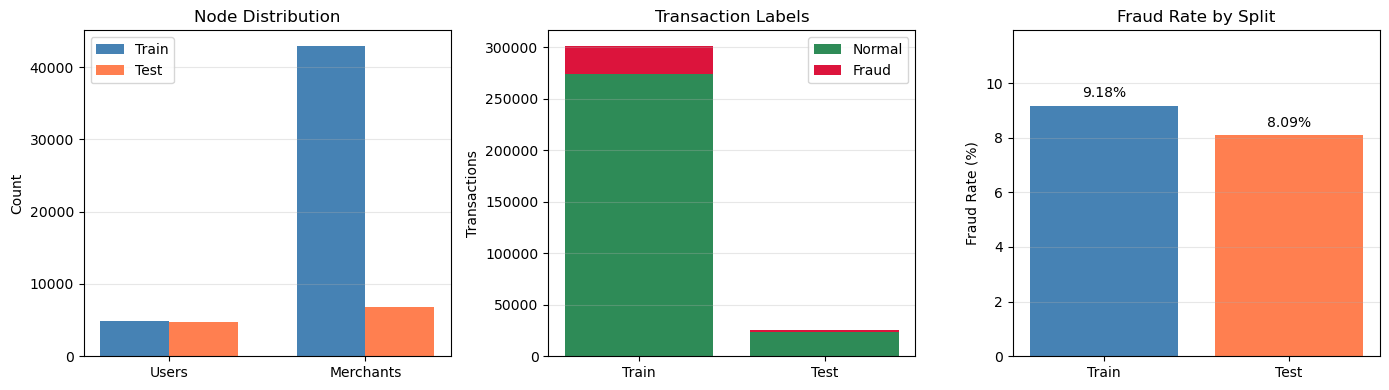

In [21]:
import pandas as pd
import matplotlib.pyplot as plt

def summarize_graph(gnn_dir):
    """Summarize the preprocessed GNN graph structure."""
    
    # Load training graph data
    edges_df = pd.read_csv(os.path.join(gnn_dir, "edges", "user_to_merchant.csv"))
    labels_df = pd.read_csv(os.path.join(gnn_dir, "edges", "user_to_merchant_label.csv"))
    users_df = pd.read_csv(os.path.join(gnn_dir, "nodes", "user.csv"))
    merchants_df = pd.read_csv(os.path.join(gnn_dir, "nodes", "merchant.csv"))
    
    # Load test graph data
    test_edges_df = pd.read_csv(os.path.join(gnn_dir, "test_gnn", "edges", "user_to_merchant.csv"))
    test_labels_df = pd.read_csv(os.path.join(gnn_dir, "test_gnn", "edges", "user_to_merchant_label.csv"))
    test_users_df = pd.read_csv(os.path.join(gnn_dir, "test_gnn", "nodes", "user.csv"))
    test_merchants_df = pd.read_csv(os.path.join(gnn_dir, "test_gnn", "nodes", "merchant.csv"))
    
    # Calculate statistics
    num_users = len(users_df)
    num_merchants = len(merchants_df)
    num_transactions = len(edges_df)
    num_fraud = labels_df['Fraud'].sum()
    fraud_rate = num_fraud / num_transactions * 100
    
    test_num_users = len(test_users_df)
    test_num_merchants = len(test_merchants_df)
    test_num_transactions = len(test_edges_df)
    test_num_fraud = test_labels_df['Fraud'].sum()
    test_fraud_rate = test_num_fraud / test_num_transactions * 100
    
    # User features and merchant features
    user_features = users_df.shape[1]
    merchant_features = merchants_df.shape[1]
    edge_attr_df = pd.read_csv(os.path.join(gnn_dir, "edges", "user_to_merchant_attr.csv"))
    edge_features = edge_attr_df.shape[1]
    
    # Print summary
    print("=" * 60)
    print("  GRAPH SUMMARY: User-Merchant Transaction Network")
    print("=" * 60)
    print()
    print("  Graph Type: Bipartite (Users ↔ Merchants)")
    print("  Edge Type:  Transactions (with fraud labels)")
    print()
    print("  ┌─────────────────────────────────────────────────────┐")
    print("  │                   TRAINING SET                      │")
    print("  ├─────────────────────────────────────────────────────┤")
    print(f"  │  Users (nodes):        {num_users:>10,}                  │")
    print(f"  │  Merchants (nodes):    {num_merchants:>10,}                  │")
    print(f"  │  Transactions (edges): {num_transactions:>10,}                  │")
    print(f"  │  Fraudulent:           {num_fraud:>10,} ({fraud_rate:.2f}%)         │")
    print("  └─────────────────────────────────────────────────────┘")
    print()
    print("  ┌─────────────────────────────────────────────────────┐")
    print("  │                     TEST SET                        │")
    print("  ├─────────────────────────────────────────────────────┤")
    print(f"  │  Users (nodes):        {test_num_users:>10,}                  │")
    print(f"  │  Merchants (nodes):    {test_num_merchants:>10,}                  │")
    print(f"  │  Transactions (edges): {test_num_transactions:>10,}                  │")
    print(f"  │  Fraudulent:           {test_num_fraud:>10,} ({test_fraud_rate:.2f}%)         │")
    print("  └─────────────────────────────────────────────────────┘")
    print()
    print("  ┌─────────────────────────────────────────────────────┐")
    print("  │                 FEATURE DIMENSIONS                  │")
    print("  ├─────────────────────────────────────────────────────┤")
    print(f"  │  User features:        {user_features:>10}                  │")
    print(f"  │  Merchant features:    {merchant_features:>10}                  │")
    print(f"  │  Edge (tx) features:   {edge_features:>10}                  │")
    print("  └─────────────────────────────────────────────────────┘")
    print()
    
    # Visualization
    fig, axes = plt.subplots(1, 3, figsize=(14, 4))
    
    # 1. Node distribution
    ax1 = axes[0]
    categories = ['Users', 'Merchants']
    train_counts = [num_users, num_merchants]
    test_counts = [test_num_users, test_num_merchants]
    x = range(len(categories))
    width = 0.35
    ax1.bar([i - width/2 for i in x], train_counts, width, label='Train', color='steelblue')
    ax1.bar([i + width/2 for i in x], test_counts, width, label='Test', color='coral')
    ax1.set_ylabel('Count')
    ax1.set_title('Node Distribution')
    ax1.set_xticks(x)
    ax1.set_xticklabels(categories)
    ax1.legend()
    ax1.grid(axis='y', alpha=0.3)
    
    # 2. Fraud vs Normal transactions
    ax2 = axes[1]
    labels = ['Train', 'Test']
    fraud_counts = [num_fraud, test_num_fraud]
    normal_counts = [num_transactions - num_fraud, test_num_transactions - test_num_fraud]
    ax2.bar(labels, normal_counts, label='Normal', color='seagreen')
    ax2.bar(labels, fraud_counts, bottom=normal_counts, label='Fraud', color='crimson')
    ax2.set_ylabel('Transactions')
    ax2.set_title('Transaction Labels')
    ax2.legend()
    ax2.grid(axis='y', alpha=0.3)
    
    # 3. Fraud rate comparison
    ax3 = axes[2]
    ax3.bar(['Train', 'Test'], [fraud_rate, test_fraud_rate], color=['steelblue', 'coral'])
    ax3.set_ylabel('Fraud Rate (%)')
    ax3.set_title('Fraud Rate by Split')
    ax3.set_ylim(0, max(fraud_rate, test_fraud_rate) * 1.3)
    for i, v in enumerate([fraud_rate, test_fraud_rate]):
        ax3.text(i, v + 0.3, f'{v:.2f}%', ha='center', fontsize=10)
    ax3.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'train': {'users': num_users, 'merchants': num_merchants, 'transactions': num_transactions, 'fraud': num_fraud},
        'test': {'users': test_num_users, 'merchants': test_num_merchants, 'transactions': test_num_transactions, 'fraud': test_num_fraud},
        'features': {'user': user_features, 'merchant': merchant_features, 'edge': edge_features}
    }

# Run the summary
gnn_dir = os.path.join(data_root_dir, "gnn")
graph_stats = summarize_graph(gnn_dir)

In [ ]:
# copy data to S3 to get pulled during training
! aws s3 sync "../data/TabFormer/" s3://$bucket_name/data/ --exclude "*/test_gnn" --force --delete

-----
# Step 3:  Now train the model using the financial-fraud-training container


## Create training configuration file
NOTE: Training configuration file must conform to schema defined in docs (to be updated.)

__Important: Models and configuration files needed for deployment using NVIDIA Dynamo-Triton will be saved in model-repository under the folder that is mounted in /trained_models inside the container__

In [17]:
training_config = {
  "paths": {
        "data_dir": "/opt/ml/input/data/data",
        "output_dir": "/opt/ml/model"
  },

  "models": [
    {
      "kind": "GNN_XGBoost",
      "gpu": "single",
      "hyperparameters": {
        "gnn":{
          "hidden_channels": 32,
          "n_hops": 2,
          "layer": "SAGEConv",
          "dropout_prob": 0.1,
          "batch_size": 4096,
          "fan_out": 10,
          "num_epochs": 20
        },
        "xgb": {
          "max_depth": 6,
          "learning_rate": 0.2,
          "num_parallel_tree": 3,
          "num_boost_round": 512,
          "gamma": 0.0
        }

      }
    }
  ]
}


#### Save the training configuration as a json file

In [25]:
training_config_file_name = 'training_config.json'

with open(os.path.join(training_config_file_name), 'w') as json_file:
    json.dump(training_config, json_file, indent=4)

# clone config to S3
! aws s3 cp ./training_config.json s3://$bucket_name/config/training_config.json

upload: ./training_config.json to s3://ml-on-containers-541765610078/config/training_config.json


## Train model using financial_fraud_training container

In [18]:
# ------------------------------------------------------------------
# 1. Define training job name
# ------------------------------------------------------------------
training_job_name = "fraud-detection-gnn-" + str(int(time.time()))

# ------------------------------------------------------------------
# 2. Send training job name to Parameter Store
# ------------------------------------------------------------------
ssm_client = boto3.client("ssm")
ssm_client.put_parameter(
    Name="/triton/model", 
    Value=training_job_name, 
    Overwrite=True, 
    Type="String"
)

# ------------------------------------------------------------------
# 3. PREPARE CUSTOM ENTRYPOINT SCRIPT
# ------------------------------------------------------------------

# CONFIGURATION:
# Change this to "cuda-compat-13-0" to try CUDA 13.
# WARNING: CUDA 13.0 generally requires Host Driver >= 580.
# If SageMaker logs show "cudaErrorInsufficientDriver", revert to "cuda-compat-12-2"
CUDA_COMPAT_VERSION = "cuda-compat-13-0" 

# NOTE: We use a multi-line f-string (triple quotes) here. 
# Ensure your editor handles the mixing of python f-string braces {} 
# and bash variables like $LD_LIBRARY_PATH correctly.
entrypoint_script_content = f"""#!/bin/bash
set -e  # Exit immediately if any command fails

echo "--- HOST DEBUG INFO ---"
cat /etc/os-release
echo "NVIDIA Driver Version on Host:"
nvidia-smi --query-gpu=driver_version --format=csv,noheader
echo "-----------------------"

echo "Starting custom setup..."

# A. Install Python dependencies
pip install --upgrade boto3 pandas

# B. Install System/CUDA packages
# We accept failure (|| true) on apt-get update in case of transient network issues,
# but the install must succeed.
apt-get update || true
apt-get install -y {CUDA_COMPAT_VERSION}

# C. Configure Linker for Forward Compatibility
# The compat package installs libs to /usr/local/cuda/compat
export LD_LIBRARY_PATH=/usr/local/cuda/compat:$LD_LIBRARY_PATH

echo "Setup complete. Launching training..."

# D. Run the actual training command
# We use exec to replace the shell process with torchrun
exec torchrun --standalone --nnodes=1 --nproc_per_node=1 /app/main.py --config /opt/ml/input/data/config/training_config.json
"""

# Initialize S3 client
s3_client = boto3.client('s3')

# Define where the script will live
script_key = f"code/{training_job_name}/entrypoint.sh"
script_s3_uri = f"s3://{bucket_name}/{script_key}"

# Upload the script
s3_client.put_object(
    Body=entrypoint_script_content,
    Bucket=bucket_name,
    Key=script_key
)
print(f"Uploaded custom entrypoint to {script_s3_uri}")

# ------------------------------------------------------------------
# 4. Create the Training Job
# ------------------------------------------------------------------
sagemaker_client = boto3.client('sagemaker')

response = sagemaker_client.create_training_job(
    TrainingJobName=training_job_name,
    RoleArn=sagemaker_training_role,
    AlgorithmSpecification={
        'TrainingImage': f"{training_repo}:latest",
        'TrainingInputMode': 'File',
        
        # Override entrypoint to Bash to allow our custom setup script to run
        'ContainerEntrypoint': ['/bin/bash', '-c'],
        
        # Command: Install AWS CLI -> Download script -> Run script
        # We added "pip install awscli" to fix the error.
        'ContainerArguments': [
            f"pip install awscli && aws s3 cp {script_s3_uri} /tmp/run.sh && bash /tmp/run.sh"
        ]
    },
    InputDataConfig=[
        {
            'ChannelName': 'data',
            'DataSource': {
                'S3DataSource': {
                    'S3DataType': 'S3Prefix',
                    'S3Uri': f's3://{bucket_name}/data/gnn/',
                    'S3DataDistributionType': 'FullyReplicated'
                }
            },
            'ContentType': 'application/x-directory',
            'InputMode': 'File',
            'CompressionType': 'None'
        },
        {
            'ChannelName': 'config',
            'DataSource': {
                'S3DataSource': {
                    'S3DataType': 'S3Prefix',
                    'S3Uri': f's3://{bucket_name}/config/',
                    'S3DataDistributionType': 'FullyReplicated',
                }
            },
            'ContentType': 'application/x-directory',
            'InputMode': 'File',
            'CompressionType': 'None'
        }
    ],
    OutputDataConfig={
        'S3OutputPath': f's3://{bucket_name}/output/'
    },
    ResourceConfig={
        'InstanceType': 'ml.g5.xlarge',
        'InstanceCount': 1,
        'VolumeSizeInGB': 30
    },
    StoppingCondition={
        'MaxRuntimeInSeconds': 86400
    }
)

print(f"Training job started: {response['TrainingJobArn']}")

Uploaded custom entrypoint to s3://ml-on-containers-541765610078/code/fraud-detection-gnn-1765204240/entrypoint.sh
Training job started: arn:aws:sagemaker:us-east-1:541765610078:training-job/fraud-detection-gnn-1765204240


#### Make sure that the training job succeeds
According to the training configuration file defined earlier, if the training runs successfully

In [45]:
from IPython.display import clear_output
def poll_training_status(job_name):
    sagemaker_client = boto3.client('sagemaker')
    
    while True:
        response = sagemaker_client.describe_training_job(TrainingJobName=job_name)
        status = response['TrainingJobStatus']
        
        # Clear previous output
        clear_output(wait=True)
        
        # Print current status with timestamp
        print(f"Job: {job_name}")
        print(f"Status: {status}")
        print(f"Last checked: {time.strftime('%Y-%m-%d %H:%M:%S')}")
        
        if status in ['Completed', 'Failed', 'Stopped']:
            break
            
        # Wait before next check
        time.sleep(30)
    
    return status

In [ ]:
# =============================================================================
# QUICK START: Run this cell to skip directly to inference
# =============================================================================
# This cell initializes all required variables using existing preprocessed data.
# You can run this instead of cells 1-38 if the data is already preprocessed.

import os
import sys
import numpy as np
import pandas as pd
import boto3

# --- Data paths ---
data_root_dir = os.path.abspath('../data/TabFormer/')
model_output_dir = os.path.join(data_root_dir, 'trained_models')
gnn_data_dir = os.path.join(data_root_dir, 'gnn')

# --- Load feature masks from preprocessed files ---
def load_feature_masks(gnn_dir):
    """
    Load feature masks from preprocessed CSV files and reconstruct 
    the mask mapping dictionaries (base feature name -> mask index).
    """
    test_gnn = os.path.join(gnn_dir, 'test_gnn')
    
    def reconstruct_mask_map(columns, mask_array):
        """Reconstruct mask_map dict from column names and mask array."""
        mask_map = {}
        for col, mask_val in zip(columns, mask_array):
            # Extract base feature name (before underscore for encoded columns)
            base_feature = col.split("_")[0] if "_" in col else col
            if base_feature not in mask_map:
                mask_map[base_feature] = int(mask_val)
        return mask_map
    
    # Load user features
    user_df = pd.read_csv(os.path.join(test_gnn, 'nodes', 'user.csv'), nrows=0)
    user_mask = np.loadtxt(os.path.join(test_gnn, 'nodes', 'user_feature_mask.csv'), delimiter=',', dtype=np.int32)
    user_mask_map = reconstruct_mask_map(user_df.columns, user_mask)
    
    # Load merchant features
    merchant_df = pd.read_csv(os.path.join(test_gnn, 'nodes', 'merchant.csv'), nrows=0)
    merchant_mask = np.loadtxt(os.path.join(test_gnn, 'nodes', 'merchant_feature_mask.csv'), delimiter=',', dtype=np.int32)
    mx_mask_map = reconstruct_mask_map(merchant_df.columns, merchant_mask)
    
    # Load transaction (edge) features
    tx_df = pd.read_csv(os.path.join(test_gnn, 'edges', 'user_to_merchant_attr.csv'), nrows=0)
    tx_mask = np.loadtxt(os.path.join(test_gnn, 'edges', 'user_to_merchant_feature_mask.csv'), delimiter=',', dtype=np.int32)
    tx_mask_map = reconstruct_mask_map(tx_df.columns, tx_mask)
    
    return user_mask_map, mx_mask_map, tx_mask_map

# --- Get inference host from AWS ---
def get_inference_host():
    """Get Triton inference host from AWS ELB."""
    try:
        elb_client = boto3.client('elbv2', region_name="us-east-1")
        response = elb_client.describe_load_balancers()["LoadBalancers"]
        for elb in response:
            if elb['LoadBalancerName'].startswith('k8s-triton'):
                return elb['DNSName']
    except Exception as e:
        print(f"Could not get inference host from AWS: {e}")
        print("Please set HOST manually below.")
    return None

# --- Initialize variables ---
inference_host = get_inference_host()

# Triton connection settings
HOST = inference_host  # Or set manually: HOST = "your-triton-host.amazonaws.com"
HTTP_PORT = 80
GRPC_PORT = 8006
METRICS_PORT = 8007

# --- Verify and load data ---
test_gnn_path = os.path.join(gnn_data_dir, 'test_gnn')
if os.path.exists(test_gnn_path):
    print("✓ Preprocessed GNN data found")
    print(f"  Data path: {gnn_data_dir}")
    
    # Load feature mask mappings (dict: base_feature -> mask_index)
    user_mask_map, mx_mask_map, tx_mask_map = load_feature_masks(gnn_data_dir)
    print(f"✓ Feature mask mappings loaded:")
    print(f"    user_mask_map:        {len(user_mask_map)} features {list(user_mask_map.keys())}")
    print(f"    mx_mask_map:          {len(mx_mask_map)} features {list(mx_mask_map.keys())}")
    print(f"    tx_mask_map:          {len(tx_mask_map)} features {list(tx_mask_map.keys())}")
else:
    print("✗ Preprocessed data not found. Please run preprocessing first (cells 21-24).")
    user_mask_map, mx_mask_map, tx_mask_map = None, None, None

if HOST:
    print(f"✓ Inference host: {HOST}")
else:
    print("✗ Inference host not found. Set HOST manually.")

print(f"\nReady to run inference cells (Step 4 onwards).")

NameError: name 'training_job_name' is not defined

## Quick Start: Skip to Inference

**Run this cell if you want to skip preprocessing and training steps.**  
This initializes all required variables using existing preprocessed data.

In [ ]:
# =============================================================================
# QUICK START: Run this cell to skip directly to inference
# =============================================================================
# This cell initializes all required variables using existing preprocessed data.
# You can run this instead of cells 1-38 if the data is already preprocessed.

import os
import sys
import numpy as np
import pandas as pd
import boto3

# --- Data paths ---
data_root_dir = os.path.abspath('../data/TabFormer/')
model_output_dir = os.path.join(data_root_dir, 'trained_models')
gnn_data_dir = os.path.join(data_root_dir, 'gnn')

# --- Load feature masks from preprocessed files ---
def load_feature_masks(gnn_dir):
    """Load feature masks from preprocessed CSV files."""
    test_gnn = os.path.join(gnn_dir, 'test_gnn')
    
    user_mask = np.loadtxt(os.path.join(test_gnn, 'nodes', 'user_feature_mask.csv'), delimiter=',', dtype=np.int32)
    merchant_mask = np.loadtxt(os.path.join(test_gnn, 'nodes', 'merchant_feature_mask.csv'), delimiter=',', dtype=np.int32)
    tx_mask = np.loadtxt(os.path.join(test_gnn, 'edges', 'user_to_merchant_feature_mask.csv'), delimiter=',', dtype=np.int32)
    
    return user_mask, merchant_mask, tx_mask

# --- Get inference host from AWS ---
def get_inference_host():
    """Get Triton inference host from AWS ELB."""
    try:
        elb_client = boto3.client('elbv2', region_name="us-east-1")
        response = elb_client.describe_load_balancers()["LoadBalancers"]
        for elb in response:
            if elb['LoadBalancerName'].startswith('k8s-triton'):
                return elb['DNSName']
    except Exception as e:
        print(f"Could not get inference host from AWS: {e}")
        print("Please set HOST manually below.")
    return None

# --- Initialize variables ---
inference_host = get_inference_host()

# Triton connection settings
HOST = inference_host  # Or set manually: HOST = "your-triton-host.amazonaws.com"
HTTP_PORT = 80
GRPC_PORT = 8006
METRICS_PORT = 8007

# --- Verify and load data ---
test_gnn_path = os.path.join(gnn_data_dir, 'test_gnn')
if os.path.exists(test_gnn_path):
    print("✓ Preprocessed GNN data found")
    print(f"  Data path: {gnn_data_dir}")
    
    # Load feature masks
    user_mask_map, mx_mask_map, tx_mask_map = load_feature_masks(gnn_data_dir)
    print(f"✓ Feature masks loaded:")
    print(f"    user_mask_map:        {user_mask_map.shape}")
    print(f"    mx_mask_map:          {mx_mask_map.shape}")
    print(f"    tx_mask_map:          {tx_mask_map.shape}")
else:
    print("✗ Preprocessed data not found. Please run preprocessing first (cells 21-24).")
    user_mask_map, mx_mask_map, tx_mask_map = None, None, None

if HOST:
    print(f"✓ Inference host: {HOST}")
else:
    print("✗ Inference host not found. Set HOST manually.")

print(f"\nReady to run inference cells (Step 4 onwards).")

----
# Step 4:  Serve your python backend model using NVIDIA Dynamo-Triton
__!Important__: Change MODEL_REPO_PATH to point to `{model_output_dir}` / `python_backend_model_repository` if you used a different path in your training configuration file

#### Install NVIDIA Dynamo-Triton Client

In [18]:
!pip install 'tritonclient[all]'

In [19]:
import tritonclient.grpc as triton_grpc
import tritonclient.http as httpclient
from tritonclient import utils as triton_utils


##### Replace HOST with the actual URL where your NVIDIA Dynamo-Triton server is hosted.


In [20]:
HOST = inference_host
HTTP_PORT = 80
GRPC_PORT = 8006
METRICS_PORT = 8007

### Serve your models with NVIDIA Dynamo-Triton

With the infrastructure repo deployed, we have a Lambda function waiting for the training job to complete and for the models to be output to `s3://ml-on-containers-<accountnumber>/output` and then, they'll get extracted to a different bucket to be served by the inference host setup by our infrastructure.

### URLs for GRPC and HTTP request to the inference server

In [21]:
client_grpc = triton_grpc.InferenceServerClient(url=f'{HOST}:{GRPC_PORT}')
client_http = httpclient.InferenceServerClient(url=f'{HOST}:{HTTP_PORT}')

#### Here’s an example of how to prepare data for inference, using random data

In [22]:
import numpy as np

from tritonclient.http import InferenceServerClient, InferInput, InferRequestedOutput

def make_example_request():
    # -- example sizes --
    num_merchants = 5
    num_users   = 7
    num_edges   = 3
    merchant_feature_dim = 24
    user_feature_dim = 13
    user_to_merchant_feature_dim = 38

    # -- 1) features --
    x_merchant = np.random.randn(num_merchants, merchant_feature_dim).astype(np.float32)
    x_user   = np.random.randn(num_users, user_feature_dim).astype(np.float32)

    # -- 2) shap flag and masks --
    compute_shap          = np.array([True], dtype=np.bool_)
    feature_mask_merchant   = np.random.randint(0,2, size=(merchant_feature_dim,), dtype=np.int32)
    feature_mask_user     = np.random.randint(0,2, size=(user_feature_dim,), dtype=np.int32)

    # -- 3) edges: index [2, num_edges] and attributes [num_edges,user_to_merchant_feature_dim] --
    edge_index_user_to_merchant = np.vstack([
        np.random.randint(0, num_users,   size=(num_edges,)),
        np.random.randint(0, num_merchants, size=(num_edges,))
    ]).astype(np.int64)
    
    edge_attr_user_to_merchant = np.random.randn(num_edges, user_to_merchant_feature_dim).astype(np.float32)

    feature_mask_user_to_merchant =  np.random.randint(0,2, size=(user_to_merchant_feature_dim,), dtype=np.int32)

    return {
        "x_merchant": x_merchant,
        "x_user": x_user,
        "COMPUTE_SHAP": compute_shap,
        "feature_mask_merchant": feature_mask_merchant,
        "feature_mask_user": feature_mask_user,
        "edge_index_user_to_merchant": edge_index_user_to_merchant,
        "edge_attr_user_to_merchant": edge_attr_user_to_merchant,
        "edge_feature_mask_user_to_merchant": feature_mask_user_to_merchant
    }



In [16]:
def prepare_and_send_inference_request(data):

    # Connect to Triton
    client = httpclient.InferenceServerClient(url=f'{HOST}:{HTTP_PORT}')

    # Prepare Inputs

    inputs = []
    def _add_input(name, arr, dtype):
        inp = InferInput(name, arr.shape, datatype=dtype)
        inp.set_data_from_numpy(arr)
        inputs.append(inp)

    for key, value in data.items():
        if key.startswith("x_"):
            dtype = "FP32"
        elif key.startswith("feature_mask_"):
            dtype = "INT32"
        elif key.startswith("edge_feature_mask_"):
            dtype = "INT32"            
        elif key.startswith("edge_index_"):
            dtype = "INT64"
        elif key.startswith("edge_attr_"):
            dtype = "FP32"
        elif key == "COMPUTE_SHAP":
            dtype = "BOOL"
        else:
            continue  # skip things we don't care about

        _add_input(key, value, dtype)


    # Outputs

    outputs = [InferRequestedOutput("PREDICTION")]

    for key in data:
        if key.startswith("x_"):
            node = key[len("x_"):]  # extract node name
            outputs.append(InferRequestedOutput(f"shap_values_{node}"))
        elif key.startswith("edge_attr_"):
            edge_name = key[len("edge_attr_"):]  # extract edge name
            outputs.append(InferRequestedOutput(f"shap_values_{edge_name}"))
    
    # Send request

    model_name="prediction_and_shapley"
    response = client.infer(
        model_name,
        inputs=inputs,
        request_id=str(1),
        outputs=outputs,
        timeout= 3000
    )

    result = {}

    # always include prediction
    result["PREDICTION"] = response.as_numpy("PREDICTION")

    # add shap values
    for key in data:
        if key.startswith("x_"):
            node = key[len("x_"):]  # e.g. "merchant", "user"
            result[f"shap_values_{node}"] = response.as_numpy(f"shap_values_{node}")
        if key.startswith("edge_attr_"):
            edge_name = key[len("edge_attr_"):]  # e.g. ("user" "to"  "merchant")
            result[f"shap_values_{edge_name}"] = response.as_numpy(f"shap_values_{edge_name}")
    
    return result


## Prediction without computing Shapley values

### Read preprocessed input transactions to send query to NVIDIA Dynamo-Triton

In [15]:
import os
import pandas as pd
import numpy as np

def load_hetero_graph(gnn_data_dir):
    """
    Reads:
      - All node CSVs from nodes/, plus their matching feature masks (<node>_feature_mask.csv)
        If missing, a mask of all ones is created (np.int32).
      - All edge CSVs from edges/:
          base        -> edge_index_<edge> (np.int64)
          *_attr.csv  -> edge_attr_<edge>  (np.float32)
          *_label.csv -> exactly one -> edge_label_<edge> (DataFrame)
    """
    base = os.path.join(gnn_data_dir, "test_gnn")
    nodes_dir = os.path.join(base, "nodes")
    edges_dir = os.path.join(base, "edges")

    out = {}
    node_feature_mask = {}

    # --- Nodes: every CSV becomes x_<node>; also read/create feature_mask_<node> ---
    if os.path.isdir(nodes_dir):
        for fname in os.listdir(nodes_dir):
            if fname.lower().endswith(".csv") and not fname.lower().endswith("_feature_mask.csv"):
                node_name = fname[:-len(".csv")]
                node_path = os.path.join(nodes_dir, fname)
                node_df = pd.read_csv(node_path)
                out[f"x_{node_name}"] = node_df.to_numpy(dtype=np.float32)

                # feature mask file (optional)
                mask_fname = f"{node_name}_feature_mask.csv"
                mask_path = os.path.join(nodes_dir, mask_fname)
                if os.path.exists(mask_path):
                    mask_df = pd.read_csv(mask_path, header=None)
                    node_feature_mask[node_name] = mask_df
                    feature_mask = mask_df.to_numpy(dtype=np.int32).ravel()
                else:
                    # create a must with all zeros
                    feature_mask = np.zeros(node_df.shape[1], dtype=np.int32)
                out[f"feature_mask_{node_name}"] = feature_mask

    # --- Edges: group into base, attr, label by filename suffix ---
    base_edges = {}
    edge_attrs = {}
    edge_labels = {}
    edge_feature_mask = {}

    if os.path.isdir(edges_dir):
        for fname in os.listdir(edges_dir):
            if not fname.lower().endswith(".csv"):
                continue
            path = os.path.join(edges_dir, fname)
            lower = fname.lower()
            if lower.endswith("_attr.csv"):
                edge_name = fname[:-len("_attr.csv")]
                edge_attrs[edge_name] = pd.read_csv(path) #, header=None)
            elif lower.endswith("_label.csv"):
                edge_name = fname[:-len("_label.csv")]
                edge_labels[edge_name] = pd.read_csv(path)
            elif lower.endswith("_feature_mask.csv"):
                edge_name = fname[:-len("_feature_mask.csv")]
                edge_feature_mask[edge_name] = pd.read_csv(path, header=None)
            else:
                edge_name = fname[:-len(".csv")]
                base_edges[edge_name] = pd.read_csv(path) #, header=None)



    # Enforce: only one label file total
    if len(edge_labels) == 0:
        raise FileNotFoundError("No '*_label.csv' found in edges/. Exactly one label file is required.")
    if len(edge_labels) > 1:
        raise ValueError(f"Found multiple label files: {list(edge_labels.keys())}. Exactly one is allowed.")

    # Build output keys for edges
    for edge_name, df in base_edges.items():
        out[f"edge_index_{edge_name}"] = df.to_numpy(dtype=np.int64).T
        if edge_name in edge_attrs:
            out[f"edge_attr_{edge_name}"] = edge_attrs[edge_name].to_numpy(dtype=np.float32)
        if edge_name in edge_feature_mask:
            out[f"edge_feature_mask_{edge_name}"] = edge_feature_mask[edge_name].to_numpy(dtype=np.int32).ravel()
        else:
            # create a must with all zeros
            out[f"edge_feature_mask_{edge_name}"] = np.zeros(edge_attrs[edge_name].shape[1], dtype=np.int32)

        

    # Add the single label file (kept as DataFrame)
    (label_edge_name, label_df), = edge_labels.items()
    out[f"edge_label_{label_edge_name}"] = label_df

    return out

In [23]:
gnn_data_dir = os.path.join(data_root_dir, "gnn")
test_data = load_hetero_graph(gnn_data_dir)
compute_shap = False
result =  prepare_and_send_inference_request(test_data | {"COMPUTE_SHAP": np.array([compute_shap], dtype=np.bool_)})

In [24]:
len(result['PREDICTION'])

25803

### Evaluate performance on test data

In [25]:
from sklearn.metrics import (
    confusion_matrix,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score)
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


In [26]:

def compute_score_for_batch(y, predictions, decision_threshold = 0.5):
    # Apply threshold
    y_pred = (predictions > decision_threshold).astype(int)

    # Compute evaluation metrics
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, zero_division=0)
    recall = recall_score(y, y_pred, zero_division=0)
    f1 = f1_score(y, y_pred, zero_division=0)

    # Confusion matrix
    classes = ['Non-Fraud', 'Fraud']
    columns = pd.MultiIndex.from_product([["Predicted"], classes])
    index = pd.MultiIndex.from_product([["Actual"], classes])

    conf_mat = confusion_matrix(y, y_pred)
    cm_df = pd.DataFrame(conf_mat, index=index, columns=columns)
    print(cm_df)

    # Plot the confusion matrix directly
    disp = ConfusionMatrixDisplay.from_predictions(
        y, y_pred, display_labels=classes
    )
    disp.ax_.set_title('Confusion Matrix')
    plt.show()

    # Print summary
    print("----Summary---")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")


#### Scores on test data

                 Predicted      
                 Non-Fraud Fraud
Actual Non-Fraud     23610   106
       Fraud            73  2014


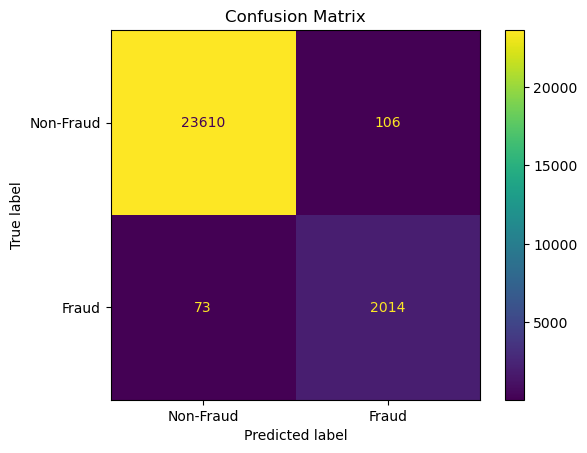

----Summary---
Accuracy:  0.9931
Precision: 0.9500
Recall:    0.9650
F1 Score:  0.9575


In [35]:
# Decision threshold to flag a transaction as fraud
#Change to trade-off precision and recall
decision_threshold = 0.5
y = test_data['edge_label_user_to_merchant'].to_numpy(dtype=np.int32)
compute_score_for_batch(y, result['PREDICTION'], decision_threshold)

# Compute Shapley values of different features for a transaction

NOTE: Shapely computation is very expensive, it will only compute shap values for first transaction.

#### Shapley values for different features

In [27]:
gnn_data_dir = "/home/sagemaker-user/TW-sample-financial-fraud-detection-with-nvidia/data/TabFormer/gnn"

test_data =  load_hetero_graph(gnn_data_dir)
compute_shap = True
result_with_shap = prepare_and_send_inference_request(test_data | {"COMPUTE_SHAP": np.array([compute_shap], dtype=np.bool_)})

In [28]:
for key in result_with_shap:
    if key.startswith('shap_'):
        print(f'{key} : {result_with_shap[key]}')

shap_values_user : [0.26864874]
shap_values_merchant : [7.3822927 1.0220313]
shap_values_user_to_merchant : [0.5657691  0.7992966  0.04602096 0.69189733 0.00849468]


In [30]:
feature_masks = {
    'user': user_mask_map,
    'merchant': mx_mask_map,
    'user_to_merchant': tx_mask_map
}

NameError: name 'user_mask_map' is not defined

In [ ]:
for key in feature_masks:
    shap_values = result_with_shap[f'shap_values_{key}']
    min_idx = min(feature_masks[key].values())

    attr_to_shap = {
        attr: float(shap_values[int(idx - min_idx)])
        for attr, idx in feature_masks[key].items()
    }
    print(attr_to_shap)

---
# Step 5: Latency and Throughput Tests

Measure inference performance with **realistic request sizes**:
- **Single transaction**: 1 edge + connected user/merchant (real-time fraud scoring)
- **Small batch**: 10-100 transactions (micro-batch processing)
- **Varying batch sizes**: Latency scaling analysis

In [60]:
import time
import numpy as np
from concurrent.futures import ThreadPoolExecutor, as_completed
import statistics

def extract_subgraph(full_data, edge_indices, gnn_data_dir):
    """
    Extract a subgraph containing only the specified edges and their connected nodes.
    
    Args:
        full_data: Full test graph data from load_hetero_graph()
        edge_indices: List of edge indices to include
        gnn_data_dir: Path to GNN data directory
    
    Returns:
        Subgraph data dict ready for inference
    """
    # Get edge data
    edge_index = full_data['edge_index_user_to_merchant']  # shape (2, num_edges)
    edge_attr = full_data['edge_attr_user_to_merchant']    # shape (num_edges, 38)
    
    # Extract selected edges
    selected_edge_index = edge_index[:, edge_indices]
    selected_edge_attr = edge_attr[edge_indices, :]
    
    # Find unique users and merchants in selected edges
    selected_users = np.unique(selected_edge_index[0, :])
    selected_merchants = np.unique(selected_edge_index[1, :])
    
    # Create mapping from old IDs to new contiguous IDs
    user_id_map = {old_id: new_id for new_id, old_id in enumerate(selected_users)}
    merchant_id_map = {old_id: new_id for new_id, old_id in enumerate(selected_merchants)}
    
    # Remap edge indices to new contiguous IDs
    remapped_edge_index = np.zeros_like(selected_edge_index)
    for i in range(selected_edge_index.shape[1]):
        remapped_edge_index[0, i] = user_id_map[selected_edge_index[0, i]]
        remapped_edge_index[1, i] = merchant_id_map[selected_edge_index[1, i]]
    
    # Extract node features for selected nodes
    x_user = full_data['x_user'][selected_users, :]
    x_merchant = full_data['x_merchant'][selected_merchants, :]
    
    # Build subgraph data
    subgraph = {
        'x_user': x_user,
        'x_merchant': x_merchant,
        'feature_mask_user': full_data['feature_mask_user'],
        'feature_mask_merchant': full_data['feature_mask_merchant'],
        'edge_index_user_to_merchant': remapped_edge_index,
        'edge_attr_user_to_merchant': selected_edge_attr,
        'edge_feature_mask_user_to_merchant': full_data['edge_feature_mask_user_to_merchant'],
    }
    
    return subgraph

def create_batch_samples(full_data, batch_size, num_samples, gnn_data_dir):
    """Create multiple subgraph samples of a given batch size."""
    num_edges = full_data['edge_index_user_to_merchant'].shape[1]
    samples = []
    
    for _ in range(num_samples):
        # Randomly select batch_size edges
        edge_indices = np.random.choice(num_edges, size=min(batch_size, num_edges), replace=False)
        subgraph = extract_subgraph(full_data, edge_indices, gnn_data_dir)
        samples.append(subgraph)
    
    return samples

def print_subgraph_stats(subgraph, label=""):
    """Print statistics about a subgraph."""
    num_users = subgraph['x_user'].shape[0]
    num_merchants = subgraph['x_merchant'].shape[0]
    num_edges = subgraph['edge_index_user_to_merchant'].shape[1]
    print(f"{label}: {num_edges} transactions, {num_users} users, {num_merchants} merchants")

### Create Realistic Test Samples
Generate subgraphs of varying sizes to simulate real-world request patterns.

In [61]:
# Load full test data
full_test_data = load_hetero_graph(gnn_data_dir)

# Create samples for different batch sizes
batch_sizes = [1, 10, 50, 100]
num_samples_per_size = 500  # Number of samples to create for each batch size

test_samples = {}
for batch_size in batch_sizes:
    samples = create_batch_samples(full_test_data, batch_size, num_samples_per_size, gnn_data_dir)
    test_samples[batch_size] = samples
    print_subgraph_stats(samples[0], f"Batch size {batch_size} (example)")

print(f"\nCreated {num_samples_per_size} samples for each batch size: {batch_sizes}")

Batch size 1 (example): 1 transactions, 1 users, 1 merchants
Batch size 10 (example): 10 transactions, 10 users, 10 merchants
Batch size 50 (example): 50 transactions, 49 users, 47 merchants
Batch size 100 (example): 100 transactions, 97 users, 86 merchants

Created 500 samples for each batch size: [1, 10, 50, 100]


### Single Transaction Latency (Real-time Fraud Scoring)
This is the most critical metric: how fast can we score a single incoming transaction?

In [62]:
def measure_latency_for_samples(samples, compute_shap=False, warmup=5):
    """Measure latency for a list of subgraph samples."""
    latencies = []
    
    # Warmup with first sample
    warmup_data = samples[0] | {"COMPUTE_SHAP": np.array([compute_shap], dtype=np.bool_)}
    for _ in range(warmup):
        prepare_and_send_inference_request(warmup_data)
    
    # Measure each sample
    for i, sample in enumerate(samples):
        request_data = sample | {"COMPUTE_SHAP": np.array([compute_shap], dtype=np.bool_)}
        
        start = time.perf_counter()
        prepare_and_send_inference_request(request_data)
        end = time.perf_counter()
        
        latencies.append((end - start) * 1000)  # Convert to ms
        
        if (i + 1) % 100 == 0:
            print(f"  Completed {i + 1}/{len(samples)} requests...")
    
    return latencies

def print_latency_stats(latencies, label=""):
    """Print latency statistics."""
    if len(latencies) < 2:
        print(f"Not enough samples for statistics (got {len(latencies)})")
        return
        
    latencies_sorted = sorted(latencies)
    n = len(latencies)
    
    print(f"\n{'='*55}")
    print(f"  {label}")
    print(f"{'='*55}")
    print(f"  Requests:    {n}")
    print(f"  Mean:        {statistics.mean(latencies):>8.2f} ms")
    print(f"  Std Dev:     {statistics.stdev(latencies):>8.2f} ms")
    print(f"  Min:         {min(latencies):>8.2f} ms")
    print(f"  Max:         {max(latencies):>8.2f} ms")
    print(f"  P50:         {latencies_sorted[int(n * 0.50)]:>8.2f} ms")
    print(f"  P90:         {latencies_sorted[int(n * 0.90)]:>8.2f} ms")
    print(f"  P95:         {latencies_sorted[int(n * 0.95)]:>8.2f} ms")
    print(f"  P99:         {latencies_sorted[min(int(n * 0.99), n-1)]:>8.2f} ms")
    print(f"{'='*55}")

In [63]:
# Measure single transaction latency (batch_size=1)
print("Measuring SINGLE TRANSACTION latency (batch_size=1)...")
single_tx_latencies = measure_latency_for_samples(test_samples[1], compute_shap=False)
print_latency_stats(single_tx_latencies, "Single Transaction Latency (without SHAP)")

Measuring SINGLE TRANSACTION latency (batch_size=1)...
  Completed 100/500 requests...
  Completed 200/500 requests...
  Completed 300/500 requests...
  Completed 400/500 requests...
  Completed 500/500 requests...

  Single Transaction Latency (without SHAP)
  Requests:    500
  Mean:           27.01 ms
  Std Dev:         0.69 ms
  Min:            25.98 ms
  Max:            31.94 ms
  P50:            26.90 ms
  P90:            27.56 ms
  P95:            27.97 ms
  P99:            30.44 ms


### Latency vs Batch Size
How does latency scale as we increase the number of transactions per request?

In [84]:
# Measure latency for different batch sizes
latency_by_batch_size = {}

for batch_size in batch_sizes:
    print(f"\nMeasuring latency for batch_size={batch_size}...")
    latencies = measure_latency_for_samples(test_samples[batch_size], compute_shap=False)
    latency_by_batch_size[batch_size] = latencies
    print_latency_stats(latencies, f"Batch Size = {batch_size} transactions")


Measuring latency for batch_size=1...
  Completed 100/500 requests...
  Completed 200/500 requests...
  Completed 300/500 requests...
  Completed 400/500 requests...
  Completed 500/500 requests...

  Batch Size = 1 transactions
  Requests:    500
  Mean:           25.84 ms
  Std Dev:         0.71 ms
  Min:            24.49 ms
  Max:            30.25 ms
  P50:            25.75 ms
  P90:            26.52 ms
  P95:            27.09 ms
  P99:            29.26 ms

Measuring latency for batch_size=10...
  Completed 100/500 requests...
  Completed 200/500 requests...
  Completed 300/500 requests...
  Completed 400/500 requests...
  Completed 500/500 requests...

  Batch Size = 10 transactions
  Requests:    500
  Mean:           27.19 ms
  Std Dev:         2.48 ms
  Min:            25.56 ms
  Max:            76.29 ms
  P50:            26.92 ms
  P90:            27.92 ms
  P95:            28.51 ms
  P99:            33.40 ms

Measuring latency for batch_size=50...
  Completed 100/500 requests

### Throughput Test (Concurrent Single-Transaction Requests)
Simulate multiple users submitting transactions simultaneously.

In [ ]:
def measure_throughput(samples, num_workers=10, compute_shap=False):
    """Measure throughput with concurrent requests using realistic single-tx samples."""
    latencies = []
    errors = 0
    
    # Cycle through samples for each request
    sample_cycle = samples * (len(samples) // num_workers + 1)  # Ensure enough samples
    
    def send_request(sample):
        try:
            request_data = sample | {"COMPUTE_SHAP": np.array([compute_shap], dtype=np.bool_)}
            start = time.perf_counter()
            prepare_and_send_inference_request(request_data)
            end = time.perf_counter()
            return (end - start) * 1000, None
        except Exception as e:
            return None, str(e)
    
    num_requests = len(samples)
    print(f"Running throughput test: {num_requests} requests, {num_workers} concurrent workers...")
    
    overall_start = time.perf_counter()
    
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        futures = [executor.submit(send_request, sample_cycle[i]) for i in range(num_requests)]
        
        for future in as_completed(futures):
            latency, error = future.result()
            if error:
                errors += 1
            else:
                latencies.append(latency)
    
    overall_end = time.perf_counter()
    total_time = overall_end - overall_start
    
    successful = len(latencies)
    throughput = successful / total_time
    
    print(f"\n{'='*55}")
    print(f"  Throughput Test Results ({num_workers} workers)")
    print(f"{'='*55}")
    print(f"  Total requests:     {num_requests}")
    print(f"  Successful:         {successful}")
    print(f"  Errors:             {errors}")
    print(f"  Total time:         {total_time:.2f} s")
    print(f"  Throughput:         {throughput:.2f} tx/s")
    if latencies:
        print(f"  Avg latency:        {statistics.mean(latencies):.2f} ms")
        print(f"  P95 latency:        {sorted(latencies)[int(len(latencies) * 0.95)]:.2f} ms")
    print(f"{'='*55}")
    
    return throughput, latencies

In [ ]:
# Test throughput with different concurrency levels using single-transaction requests
concurrency_levels = [1, 5, 10, 20]
throughput_results = {}

for num_workers in concurrency_levels:
    throughput, _ = measure_throughput(test_samples[1], num_workers=num_workers, compute_shap=False)
    throughput_results[num_workers] = throughput
    print()

### Visualizations

In [ ]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# 1. Latency vs Batch Size (box plot)
ax1 = axes[0]
batch_data = [latency_by_batch_size[bs] for bs in batch_sizes]
bp = ax1.boxplot(batch_data, labels=[str(bs) for bs in batch_sizes], patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('steelblue')
    patch.set_alpha(0.7)
ax1.set_xlabel('Batch Size (transactions)', fontsize=11)
ax1.set_ylabel('Latency (ms)', fontsize=11)
ax1.set_title('Latency vs Batch Size', fontsize=12)
ax1.grid(axis='y', alpha=0.3)

# 2. Throughput vs Concurrency
ax2 = axes[1]
workers = list(throughput_results.keys())
throughputs = list(throughput_results.values())
bars = ax2.bar(workers, throughputs, color='coral', edgecolor='black', alpha=0.8)
ax2.set_xlabel('Concurrent Workers', fontsize=11)
ax2.set_ylabel('Throughput (tx/second)', fontsize=11)
ax2.set_title('Throughput vs Concurrency\n(single-tx requests)', fontsize=12)
ax2.set_xticks(workers)
for bar, t in zip(bars, throughputs):
    ax2.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, 
             f'{t:.1f}', ha='center', fontsize=9)
ax2.grid(axis='y', alpha=0.3)

# 3. Single Transaction Latency Distribution
ax3 = axes[2]
ax3.hist(single_tx_latencies, bins=20, color='seagreen', edgecolor='black', alpha=0.7)
mean_lat = statistics.mean(single_tx_latencies)
p95_lat = sorted(single_tx_latencies)[int(len(single_tx_latencies) * 0.95)]
ax3.axvline(mean_lat, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_lat:.1f}ms')
ax3.axvline(p95_lat, color='orange', linestyle='--', linewidth=2, label=f'P95: {p95_lat:.1f}ms')
ax3.set_xlabel('Latency (ms)', fontsize=11)
ax3.set_ylabel('Frequency', fontsize=11)
ax3.set_title('Single Transaction Latency\nDistribution', fontsize=12)
ax3.legend()
ax3.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

### Summary Table

In [ ]:
# Build summary table comparing latency across batch sizes
summary_rows = []
for batch_size in batch_sizes:
    lats = latency_by_batch_size[batch_size]
    lats_sorted = sorted(lats)
    n = len(lats)
    summary_rows.append({
        'Batch Size': batch_size,
        'Mean (ms)': f"{statistics.mean(lats):.2f}",
        'P50 (ms)': f"{lats_sorted[int(n * 0.50)]:.2f}",
        'P95 (ms)': f"{lats_sorted[int(n * 0.95)]:.2f}",
        'P99 (ms)': f"{lats_sorted[min(int(n * 0.99), n-1)]:.2f}",
        'Min (ms)': f"{min(lats):.2f}",
        'Max (ms)': f"{max(lats):.2f}",
        'Latency/Tx (ms)': f"{statistics.mean(lats) / batch_size:.2f}"
    })

summary_df = pd.DataFrame(summary_rows)
summary_df.set_index('Batch Size', inplace=True)

print("\n" + "="*70)
print("  LATENCY SUMMARY BY BATCH SIZE")
print("="*70)
display(summary_df)

# Key insights
single_tx_mean = statistics.mean(latency_by_batch_size[1])
batch_100_mean = statistics.mean(latency_by_batch_size[100])
print(f"\nKey Insights:")
print(f"  - Single transaction P95 latency: {sorted(latency_by_batch_size[1])[int(len(latency_by_batch_size[1]) * 0.95)]:.2f} ms")
print(f"  - Batching 100 tx reduces per-tx latency by {(1 - (batch_100_mean/100) / single_tx_mean) * 100:.1f}%")
print(f"  - Max throughput (20 workers): {throughput_results.get(20, 'N/A'):.1f} tx/s" if 20 in throughput_results else "")